# Outline
* Introduction to Ramsey Model
* Laibson/Baro modifications
* Describe the problem we were asked to solve
* Define our system
* Explain our method of solving backwards and bisecting for the correct starting value
* Define numerical methods for solving the system
* Solve the system using our method
* Explain why results are relevant


* Stability Analysis using the Jacobian
* Explain Jacobian results
* Time elimination method
* Explain why results are relevant

* Conclusion/What did we accomplish

In [6]:
from IPython.display import Image
from IPython.core.display import HTML
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sympy as sp
from sympy.plotting import plot
import operator
from scipy.special import roots_laguerre

import timeit

np.seterr(all="ignore")

from Numerical_Methods import *

# Introduction to the Ramsey Model

### What is the Ramsey Model?

The Ramsey–Cass–Koopmans model, or Ramsey growth model, is a neoclassical model of economic growth based primarily on the work of Frank P. Ramsey. The Ramsey Model includes a system of equations for Capital (represented by K) and Consumption (represented by C). Together, we try to model the optimal growth of the economy so that we can optimize consumption and capital. Within these models, we can add functions or variables that acount for behavioral economics such as commitment technologies, present bias, and/or discounting. By the end of this study, we added these things to the Ramsey Model:
- the depreciation of capital
- the cost of technological upkeep
- present bias
- discounting
- how effective present bias is (in the short-term)
- time
- the cost of effective worker upkeep

### Modifications of the Ramsey model: a History

The Ramsey Model has been created and modified by many people over time. For instance, it is actually called the Ramsey-Cass-Koopmans model because it was originally developed by these three people. From there, it has been edited by both Laibson and Barro.

##### What the Ramsey Model was initially:

$\begin{array}{l}
\frac{d c}{d t}=0.5 \mathrm{ck}^{-0.5}-0.1 c \\
\frac{d k}{d t}=k^{0.5}-c
\end{array}$

##### How do we go about solving this?
This is an Initial Value Problem, so we solve it "forwards" or "backwards" given some initial conditions. 

For what we call "forwards" solving, these initial conditions are literally the initial values, and specify where we should begin modeling from. In our case, Economists want to find the Policy Function which is the equation that will take us to the steady state solution. This means we do not necessarily know what our initial values are. Therefore, we instead try to work "backwards" from the steady state solution.

This means, for what we call "backwards solving", we perturb, or move, slightly off of the steady state solution by some infinitesimal value and try to solve the equation backwards to find the initial values.

For our equations, we are given the initial k-value, so when solving forwards, we use it and some found c-value, otherwise, when bacwards solving, we try to work backwards from the steady state so that we arrive perfectly at the given k-value, which proves difficult. We will outline throughout this notebook how we went about doing this.

##### Definining some terms:

For clarification, the steady state solution is where the "isoclines", a.k.a. "nullclines", of our system meet. In other words, setting the equations from our system to zero, we solve for k and c, and these resulting k and c equations are our isoclines. We then find where these two lines meet. That point is our steady state solution. Theoretically, it is where k and c are stable and will NOT shoot off towards infinity. To be more clear, we are dealing with an unstable system, so if we are even slightly off of the steady state solution, our so-called solution will shoot off towards infinity or drop to zero, which is not ideal when we are trying to model our economy (for instance, we cannot maintain infinite consumption).  

##### What is an Initial Value Problem (IVP)?
An IVP is an ordinary differential equation that also has an initial condition. This initial condition specifies a specific solution, a function, for a given time frame within the domain. Modeling systems frequently means in the sciences, such as Economics for us, solving an initial value problem. For that context, the resulting equation models how the system evolves with time given the initial conditions.

In [7]:
sys = [lambda t, k,c : k**0.5 - c, lambda t, k,c : 0.5*c*(k)**(-0.5) - 0.1*c]

##### Forward-solving the original Ramsey Model:

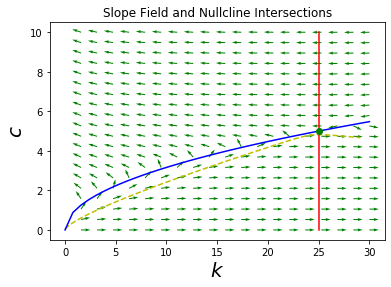

In [15]:
plot_flow(sys, [0, 30], [0, 10], 20)

#solving forward:
tf = 75

plot_IVP(sys, [0.01285009, 0.02446086], [0, tf]);

#add isoclines:
k = np.linspace(0,30,40)
c = np.sqrt(k) # dk = sqrt(k) - c with dk = 0
# dc = 0 implies 0.5/sqrt(k) - 0.1 = 0 so k = 25
plt.plot(k,c,'b',[25,25],[0,10],'r',25,5,'go')
plt.xlabel('$k$',size=20)
plt.ylabel('$c$',size=20);

##### Backward-solving the original Ramsey Model:

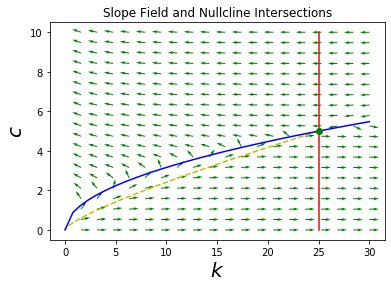

In [16]:
# the blue and red lines are isoclines, and the yellow dashed line is our solution to this IVP problem.
# we didn't modify the k-value of the isocline intersection, but we perturbed slightly off of the c-value.

plot_flow(sys, [0, 30], [0, 10], 20)

k0 = 25
perturbation = 0.01
c0 = 5-perturbation
tf =300 

plot_IVP(sys, [k0, c0], [tf, 0]);

#add isoclines:
k = np.linspace(0,30,40)
c = np.sqrt(k) # dk = sqrt(k) - c with dk = 0
# dc = 0 implies 0.5/sqrt(k) - 0.1 = 0 so k = 25
plt.plot(k,c,'b',[25,25],[0,10],'r',25,5,'go')
plt.xlabel('$k$',size=20)
plt.ylabel('$c$',size=20);

# Laibson and Baro's Modifications to the Ramsey Model

### What Laibson added:

### What Baro added:

First, Baro added depreciation of capital, $\delta$, and discounting in the form of $\frac{\rho}{\beta}$, $\rho$ being the lower bound of present bias, i.e. how does a rational person that is not affected by present bias view this capital, and $\beta$ being the upper bound of present bias, or how does the person being affected by present bias view it. 

$\begin{array}{l}
\dot{c}=c\left(\alpha k^{\alpha-1}-\delta-\frac{\rho}{\beta}\right) \\
\dot{k}=k^{\alpha}-c-\delta k
\end{array}$

In simpler terms, think of how a person views going to the gym today versus how they view planning to go the gym. In the former, a person is usually much less willing to go compared to our willinging to plan to go to the gym.



# Our Problem

# The System to Solve

# Explanation of Our Method of Solving Backwards

# Solving the System Using Our Method

# Explanation of Results of our Method

# Stability Analysis using the Jacobian

# Explanation of Jacobian results